# Recommender Systems

## Overview

Recommender systems are all around us. How many of us have logged into Netflix, after watching our favourite anime, and see a whole row of anime recommendations? Or how about on Amazon, when after buying some cooking utensils, we are recommended a chef's knife set, along with some fresh meats? Or how about a new post we see on our Instagram feed from someone we don't even follow? 

Even advertisements that we see each time we are browsing the web or watching YouTube. Each of these works off of a recommender system which attempts to predict what products/content/etc we might be interested in. 

Why do we even need a recommender system? Consumers can just search for whatever they want to find isn't it? 
Well, recommender systems do have some merit! Here some some figures that show just how powerful an impact implementing a recommender system can have on your bottom line.

Recommenders implemented by the following companies account for:
* **40%** of app installs on Google Play
* **60%** of watch time on YouTube
* **35%** of purchase on Amazon
* **75%** of movie watches on Netflix <br>
[source](https://www.mckinsey.com/industries/retail/our-insights/how-retailers-can-keep-up-with-consumers)
![Daily_picks_netflix](images/Daily_picks_netflix.PNG)

However recommender systems are not without their difficulties. They usually work by using some of the following information:<br>

* past user behaviour
* behaviour of similar users
* similar items

#### This results in recommendations of similar items, like similar movies on Netflix
![netflix_more_like_this](images/netflix_more_like_this.PNG)

#### Or recommendations of what someone in your area might have just watched.

![Contextual_reco_netflix](images/Contextual_reco_netflix.PNG)

## Problem Statement:

**How can we implement our own recommender system to accurately predict the rating a user may give the movie?**

For this problem, we will use the [movielens 100k dataset](https://grouplens.org/datasets/movielens/), which was last updated in 2018. This is the latest dataset available of this size. Due to the processing power of my laptop, I have opted to use the dataset of 100k size.

As our target is to accurately predict the user rating by using a recommender system, I am using the `Root Mean Squared Error` metric, which from here on will be referred to as `rmse`. 

Let's dive into the data and first take a look any cleaning we might need to do.

---

This is the **FIRST** of five notebooks:
1. **Data Exploration and EDA (Current Notebook)**
2. [Simple Content and Collaborative Filtering Methods](2_Simple_Content_and_Collaborative_Filtering_Models.ipynb)
3. [Surprise Library Models](3_Surprise_Library_Models.ipynb)
4. [Deep Learning Part 1 ](4_Deep_Learning_Part_1_(Basic).ipynb)
5. [Deep Learning Part 2](5_Deep_Learning_Part_2_(Introducing_more_features_and_layers).ipynb)

---

# Contents of this notebook:
1. [Imports](#Imports)
3. [Reading in the data](#Reading-in-the-data)
    * [First 5 rows](#First-5-rows)
3. [Data Checks](#Data-Checks)
4. [Merging the DataFrames](#Merging-the-DataFrames)

5. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    * [Ratings](#Ratings)
    * [Times movie is rated vs the mean rating a movie gets](#Times-movie-is-rated-vs-the-mean-rating-a-movie-gets)
    * [Genre and Movie Titles](#Genre-and-Movie-Titles)
        -[Unique Movie Genres](#Unique-Movie-Genres)
        -[Movie Genres across all users](#Movie-Genres-across-all-users)
        -[Movie Tags across all users](#Movie-Tags-across-all-users)
        -[Movie Title Years](#Movie-Title-Years)
        -[Unique Movie Titles](#Unique-Movie-Titles)
        -[Movie Titles across all users](#Movie-Titles-across-all-users)
        -[Unique Movie Genres](#Unique-Movie-Genres)

---

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
# ignoring warnings 
import warnings
warnings.filterwarnings("ignore")

In [3]:
# setting global font size for charts to be 12
plt.rcParams['font.size'] = 12

---

# Reading in the data

From the README file provided with the dataset, we have some information about each dataset.
* movies.csv: This dataset has information about 9742 unique movies, with their genres. Some movies have no genres.
* ratings.csv: This dataset contains 100836 ratings from 610 users across the same 9742 movies. 
* tags.csv: This dataset contains 3683 instances of user generated tags for movies. 
* links.csv: This dataset contains identifiers that can be used to link to other sources of movie data like imdbID and tmdbID

This entire dataset was generated on September 26, 2018. More information can be found at [MovieLens](http://movielens.org).

In [128]:
# reading in all the datasets
movies = pd.read_csv('./datasets/movies.csv')
ratings = pd.read_csv('./datasets/ratings.csv')
tags = pd.read_csv('./datasets/tags.csv')
links = pd.read_csv('./datasets/links.csv')

## First 5 rows

In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [8]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


The links file is useful if we want to find a way to link the information here back to the `imdb` or `tmdb` database. Since we are focusing on building a recommender system, we will only be using the `movies`, `ratings` and the `tags` file.

From the information in the README file, we can expect the dataset to require minimal or no cleaning. Let us perform a few checks on the dataset to ensure that this is indeed the case.

---

# Data Checks

In [9]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [10]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9730 entries, 0 to 9729
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9730 non-null   int64 
 1   title    9730 non-null   object
 2   genres   9730 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.2+ KB


There seems to be no missing values, and datatypes for the `movies.csv` file seem to be in order.

---

In [11]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [12]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [13]:
ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,100836.0,3.261276e+02,1.826185e+02,1.0,1.770000e+02,3.250000e+02,4.770000e+02,6.100000e+02
movieId,100836.0,1.943530e+04,3.553099e+04,1.0,1.199000e+03,2.991000e+03,8.122000e+03,1.936090e+05
rating,100836.0,3.501557e+00,1.042529e+00,0.5,3.000000e+00,3.500000e+00,4.000000e+00,5.000000e+00
timestamp,100836.0,1.205946e+09,2.162610e+08,828124615.0,1.019124e+09,1.186087e+09,1.435994e+09,1.537799e+09


The most relevant field here would be the `rating` row. Let's zoom into that row.

In [14]:
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

It is interesting to see that the mean rating given to movies is 3.5, and additionally if we look at the different percentiles, we can clearly see that there is a skew towards higher scores as the 25th percentile is already at a `rating` of **3**, and the rest of the percentiles are a little more evenly spread out. 

This shows that there most likely is a bias among the users who do give ratings. They tend to give higher scores, which means that we need to treat scores of 3.5 and below as a below average movie, and only movies with 3.5 and above as above average movies. This is an interesting insight into our data.

We will further explore why this during the EDA portion of this notebook.

---

In [15]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [16]:
tags.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [17]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


Since we have verified that there are no null values in our dataset, and all object types in our data seem to be correct. We will proceed with some cleaning of a few of the columns, and then we will proceed with exploratory data analysis.

First let's change the pipe seperation in our `genre` columns to a space seperation so that we can use it in our EDA and modeling.

We will also replace '(no genres listed)' to 'no_genres_listed'.

In [129]:
movies['genres'] = movies['genres'].map(lambda x: x.replace('|', ' '))
movies['genres'] = movies['genres'].map(lambda x: 'no_genres_listed' 
                                        if x == '(no genres listed)' 
                                        else x)

With this done, let's move on to exploratory data analyis.

---

# Merging the DataFrames

Before we begin, let's merge all our datasets into 1 dataset. This will allow us to call just one file to access all of the data instead of three separate files.

In [130]:
# to make matters easy, we will refer to our 
# merged dataset as df.

df = pd.merge(ratings, movies, 
              how='inner', 
              on='movieId'
             )

In [131]:
df_merged_tags = pd.merge(df,tags.drop(columns=['timestamp']),
                how='left', 
                on=['userId', 'movieId']
               )

Let's check to make sure the merge is done successfully.

In [21]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure Animation Children Comedy Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure Animation Children Comedy Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure Animation Children Comedy Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure Animation Children Comedy Fantasy


In [102]:
df.sample(5)

,userId,movieId,rating,timestamp,title,genres
2534,199,356,2.0,940372744,Forrest Gump (1994),Comedy Drama Romance War
53320,528,5418,5.0,1391736760,"Bourne Identity, The (2002)",Action Mystery Thriller
80514,323,2289,3.0,1422640618,"Player, The (1992)",Comedy Crime Drama
93490,210,130444,4.0,1537632310,Ruby Red (2013),Adventure Children Fantasy Sci-Fi
13632,307,2716,3.0,1186161394,Ghostbusters (a.k.a. Ghost Busters) (1984),Action Comedy Sci-Fi


In [104]:
df.loc[[80592, 51213, 930, 78970, 53320],]

,userId,movieId,rating,timestamp,title,genres
80592,603,2961,1.0,963178906,"Story of Us, The (1999)",Comedy Drama
51213,232,64839,3.5,1234142304,"Wrestler, The (2008)",Drama
930,191,110,3.0,829760897,Braveheart (1995),Action Drama War
78970,279,143859,3.0,1506395858,"Hail, Caesar! (2016)",Comedy
53320,528,5418,5.0,1391736760,"Bourne Identity, The (2002)",Action Mystery Thriller


In [22]:
df_merged_tags.head()

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure Animation Children Comedy Fantasy,NaN
1,5,1,4.0,847434962,Toy Story (1995),Adventure Animation Children Comedy Fantasy,NaN
2,7,1,4.5,1106635946,Toy Story (1995),Adventure Animation Children Comedy Fantasy,NaN
3,15,1,2.5,1510577970,Toy Story (1995),Adventure Animation Children Comedy Fantasy,NaN
4,17,1,4.5,1305696483,Toy Story (1995),Adventure Animation Children Comedy Fantasy,NaN


The dataframe with merged tags looks a little messy, due to the nulls that were generated in the process of joining the tags. To resolve this, let's create a custom function that we will use on the dataframe with the `apply` method.

In [132]:
def genres_tags(row):
    """This function is meant to be used with the 
    'apply' method. Accepts input of a row, and outputs
    a new column 'genres+tag', which combines the 2 
    individual columns. The function ignores an null 
    values in the 'tag' column."""
    
    if str(row['tag']) == 'nan':
        row['genres+tag'] = row['genres']
    else:
        row['genres+tag'] = row['genres'] + ' ' + row['tag']
    return row

In [133]:
# creates the new column 'genres+tag'
df_merged_tags = df_merged_tags.apply(genres_tags, axis=1)

# drops the original columns as it is not needed anymore
df_merged_tags.drop(columns=['genres', 'tag'], inplace=True)

# drops any duplicates that may have been accidentally created
df_merged_tags.drop_duplicates(keep='first', inplace=True)

In [135]:
# sanity check to ensure above actions are done
df_merged_tags.sample(10)

,userId,movieId,rating,timestamp,title,genres+tag
94043,317,97,3.0,1430598706,"Hate (Haine, La) (1995)",Crime Drama
26754,20,364,5.0,1054038067,"Lion King, The (1994)",Adventure Animation Children Drama Musical IMAX
7629,266,1206,5.0,944981086,"Clockwork Orange, A (1971)",Crime Drama Sci-Fi Thriller
3853,199,527,5.0,940372656,Schindler's List (1993),Drama War
79199,567,2731,3.5,1525284802,"400 Blows, The (Les quatre cents coups) (1959)",Crime Drama heartwarming
18562,247,122882,2.0,1467644132,Mad Max: Fury Road (2015),Action Adventure Sci-Fi Thriller
89356,448,5247,4.0,1164622121,Smokey and the Bandit (1977),Action Comedy
96022,274,7258,3.5,1172110419,"Perfect Score, The (2004)",Comedy Crime
9103,376,1270,4.5,1364933313,Back to the Future (1985),Adventure Comedy Sci-Fi
78587,275,4321,3.0,1049076697,City Slickers (1991),Comedy Western


Now that we have created two merged dataframes, let's proceed with the EDA. 

---

# Exploratory Data Analysis

In this section we will attempt to glean some insights about the features present in our dataset.

## Ratings

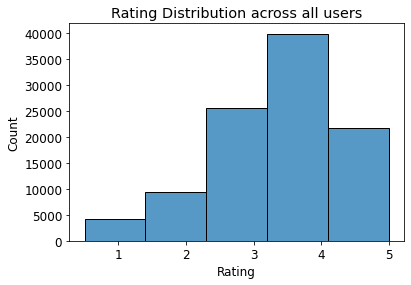

In [110]:
sns.histplot(data=df, x='rating', bins=5)
plt.title('Rating Distribution across all users')
plt.xlabel('Rating');

The above distribution confirms what we found using the `describe` method. Our users have rated the movies with a bias. Close to 40,000 users have given ratings for 4, and another 20,000+ users have given a rating of 5. That is more than half of our dataset.

We might have expected the ratings to be normally distributed around the center, i.e. **3**, however we know that the mean is instead, **3.5**. There are a few possible reasons for this:
1. Most likely, the users are subject to some sort of combination between [Central Tendency Bias and Leniency Bias](https://www.trakstar.com/blog-post/8-rater-biases-impacting-performance-management/). This could have led to a higer average rating.
2. It could be that the pool of movies that we have available, have performed better than average, and they are of higher than average quality overall, which explains the average rating of 3.5.

Let's take a look at the distribution of how often the movies were rated.

In [27]:
# get series of value counts for each movie
sr_movie_valuecounts = df['title'].value_counts().sort_values(ascending=False)

# create dataframe for plotting purposes
df_movie_valuecounts = pd.DataFrame(columns=['title', 'count'])

# add the series values into the dataframe
df_movie_valuecounts['title'] = sr_movie_valuecounts.index
df_movie_valuecounts['count'] = sr_movie_valuecounts.values

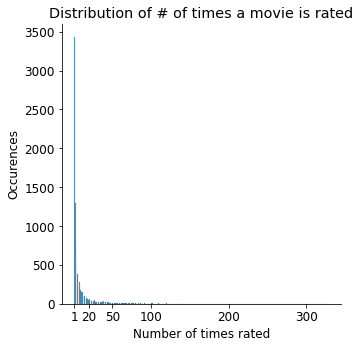

In [28]:
# plotting the distribution of the number of times each movie was watched
sns.displot(data=df_movie_valuecounts, x='count')
plt.xticks([1, 20, 50, 100, 200, 300])
plt.ylabel('Occurences')
plt.xlabel('Number of times rated')
plt.title('Distribution of # of times a movie is rated')
plt.tight_layout();

The `x-axis` above represents the number of times a movie was rated, and the `y-axis` represents the number of times this 'movie count' occured. 

For example, let's take the first datapoint on the `x-axis`, **1**, there were close to 3500 movies that were rated only 1 time. This drops drastically even as we go to movies that might have been rated 10 times. This is to be expected as there would be only few movies that would be more popular across these users.

This is where a recommender system can come into play, where if a recommender system can be personalized to each user, it can surface individual recommendations that can surface unique and interesting titles more often. This is a concept that is explored in the later deep learning notebooks

# Times a movie is watched

For this, we will simply use a `groupby` method, and check for unique `.value_counts()`. If the value is 1, it means that all the users have watched each movie that they reviewed only once.

In [136]:
df[['userId','movieId']].groupby(by='userId').value_counts().unique()

array([1], dtype=int64)

The above value makes sense, as even a user was to watch a movie again, it is unlikely that they would give it a rating a second time. Most likely, this means that if our model is trained properly, it should give recommendations that the user should not have seen before, as no user has watched the same movie twice in this dataset.

---

### Times movie is rated vs the mean rating a movie gets

In [137]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action Animation Comedy Fantasy
9738,193583,No Game No Life: Zero (2017),Animation Comedy Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action Animation


In [138]:
# defining a temp_movies df for use in this notebook only
temp_movies = pd.read_csv('./datasets/movies.csv')

In [139]:
# creating a dict where title is key and number of times it is rated is value
times_rated = df['title'].value_counts().sort_values(ascending=False).to_dict()

In [140]:
# using .map method to add times rated to temp_movies dataframe
temp_movies['times_rated'] = temp_movies['title'].map(lambda x: times_rated[x] 
                                                      if x in times_rated.keys() 
                                                      else 0
                                                     )

In [141]:
# using .map and .describe() methods to get mean fro each title and 
# adding them to the dataframe
temp_movies['mean_rating'] = temp_movies['title'].map(lambda x: df.loc[\
                                                    df['title'] == x, 
                                                    'rating'].describe()
                                                      ['mean']
                                                      if x in df['title'].unique()
                                                      else 0
                                                     )

In [142]:
temp_movies.head()

,movieId,title,genres,times_rated,mean_rating
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,215,3.920930
1,2,Jumanji (1995),Adventure Children Fantasy,110,3.431818
2,3,Grumpier Old Men (1995),Comedy Romance,52,3.259615
3,4,Waiting to Exhale (1995),Comedy Drama Romance,7,2.357143
4,5,Father of the Bride Part II (1995),Comedy,49,3.071429


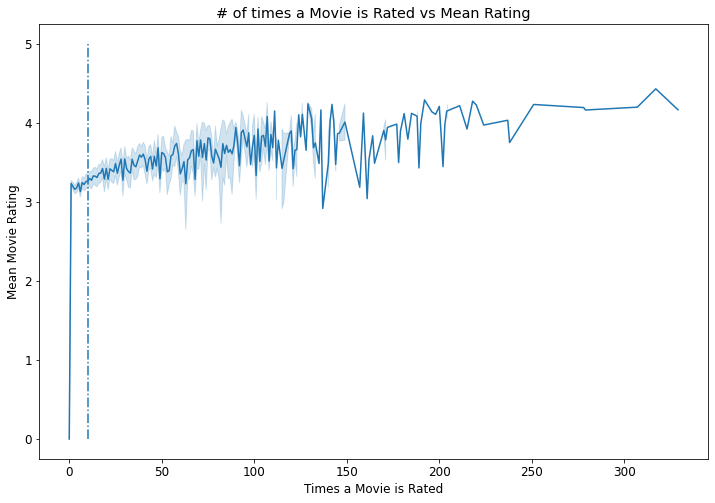

In [120]:
# creating figure object with plt
plt.figure(figsize=(12,8))

# creating line plot
sns.lineplot(data=temp_movies, x='times_rated', y='mean_rating')
plt.vlines(x=10, ymin=0, ymax=5, linestyles='dashdot')
plt.title('# of times a Movie is Rated vs Mean Rating')
plt.xlabel('Times a Movie is Rated')
plt.ylabel('Mean Movie Rating');

As we expected, the more often a movie is watched, in general, the higher it's mean rating. Only a few movies have been rated more often, but have a mean rating below 3. Let's take a look at those movies, as well as movies that have never been rated.

In [35]:
temp_movies.loc[temp_movies['mean_rating'] < 3, 
                ['title', 'times_rated', 'mean_rating', 'genres']].\
                sort_values('times_rated', ascending=False).head(8)

,title,times_rated,mean_rating,genres
126,Batman Forever (1995),137,2.916058,Action Adventure Comedy Crime
504,Home Alone (1990),116,2.995690,Children Comedy
176,Waterworld (1995),115,2.913043,Action Adventure Sci-Fi
18,Ace Ventura: When Nature Calls (1995),88,2.727273,Comedy
622,"Nutty Professor, The (1996)",82,2.731707,Comedy Fantasy Romance Sci-Fi
2700,Mission: Impossible II (2000),77,2.714286,Action Adventure Thriller
2966,Charlie's Angels (2000),72,2.722222,Action Comedy
1522,"Honey, I Shrunk the Kids (1989)",68,2.757353,Adventure Children Comedy Fantasy Sci-Fi


What is odd here is that the first movie, 'Batman Forever(1995)' was actually the fourth highest grossing film of 1995, worldwide making over $336 million. The ratings are likely to have dipped due to new viewers watching it, and comparing it to modern films where there has been a high level of advancement in CGI and special effects.

The next two movies also have large box office collections, into the hundreds of millions. I believe the reason for their rating is similar.

In [36]:
# getting movies that have not been rated 
temp_movies[temp_movies['mean_rating'] == 0]

,movieId,title,genres,times_rated,mean_rating
816,1076,"Innocents, The (1961)",Drama Horror Thriller,0,0.0
2211,2939,Niagara (1953),Drama Thriller,0,0.0
2499,3338,For All Mankind (1989),Documentary,0,0.0
2587,3456,"Color of Paradise, The (Rang-e khoda) (1999)",Drama,0,0.0
3118,4194,I Know Where I'm Going! (1945),Drama Romance War,0,0.0
4037,5721,"Chosen, The (1981)",Drama,0,0.0
4506,6668,"Road Home, The (Wo de fu qin mu qin) (1999)",Drama Romance,0,0.0
4598,6849,Scrooge (1970),Drama Fantasy Musical,0,0.0
4704,7020,Proof (1991),Comedy Drama Romance,0,0.0
5020,7792,"Parallax View, The (1974)",Thriller,0,0.0


It will be interesting to see if any of the models that we build are actually able to recommend any of these movies based on item-to-item similarity.

---

## Genre and Movie Titles

Now let's take a look at the genres that were most popular. We will do this on two levels.
1. Across the unique movies
2. Across the movies that have actually been watched by users. 

We will also take a look at the same across tags, and movie titles. We will look at this on both charts and in a wordcloud as well.

We will use the word clouds to evaluate whether there is merit to use the dataframe with combined tags, we will see if it makes a difference to the types of words associated with the movies.

In [37]:
# Create function to get top words
def plot_top_words(df, col, n, n_gram_range, title, palette='tab10'):
    """accepts dataframe, column name in text, number of words, 
    ngrams, title of chart and the color palette for chart"""
    
    def get_top_n_words(corpus, n=n, k=n_gram_range):
        """internal function that returns top n words"""
        
        # countvectorizer to vectorize words in column
        vec = CountVectorizer(ngram_range=(k,k), stop_words='english').fit(corpus)     
        bag_of_words = vec.transform(corpus)     
        sum_words = bag_of_words.sum(axis=0)      
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]    
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) 
        return words_freq[:n]
    
    # create a DataFrame of top words
    temp_df = pd.DataFrame(data=get_top_n_words(df[col], n), columns=['word','freq'])
    
    # plot the figure
    plt.figure(figsize=(10,6))
    sns.barplot(data=temp_df, y='word', x='freq', palette=palette)
    plt.ylabel('')
    plt.xlabel('')
    plt.title(title, fontsize=18)

In [38]:
def plot_wordcloud(df, col, color):
    """The Function outputs a wordcloud based 
    on the kwargs passed in.
    Accepts a dataframe, a column in the dataframe 
    and the background color to be used for the wordcloud."""
    corpus = ' '.join(df[col])
    corpus_wordcoloud = WordCloud(background_color=color,
                                  collocations=False,
                                  height=2000, 
                                  width=4000).generate(str(corpus))
    # Plot the wordcloud
    plt.figure(figsize=(15,15))
    plt.imshow(corpus_wordcoloud)
    plt.axis('off');

---

### Unique Movie Genres

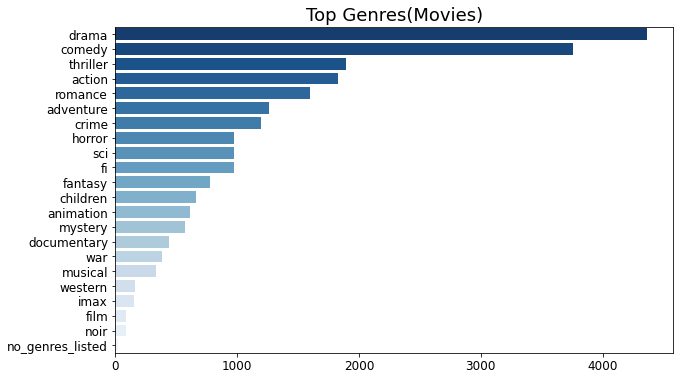

In [39]:
# plotting top unigrams for unique movies
plot_top_words(movies, 'genres', 30, 1, 'Top Genres(Movies)', 'Blues_r')

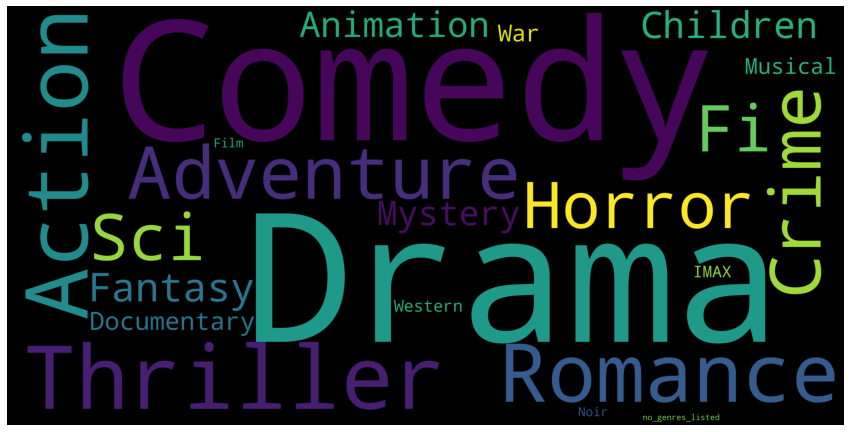

In [40]:
# plotting top unigrams for unique movies in a wordcloud
plot_wordcloud(movies, 'genres', 'Black')

As we can see, from both the unigram chart and the wordcloud, Drama and Comedy are the most popular genres of movies produced. Let's see if bigrams gives us a different picture

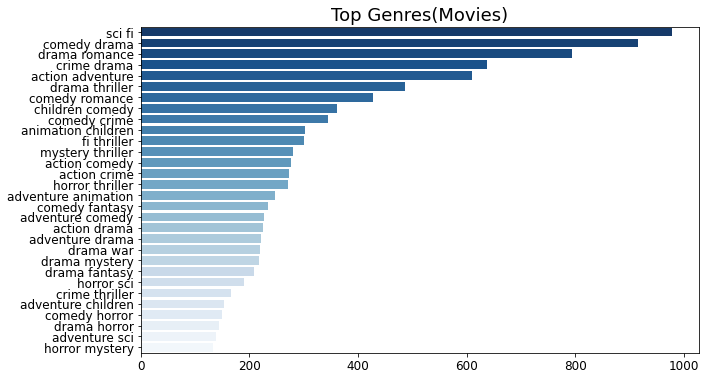

In [41]:
# plotting top bigrams for unique movies
plot_top_words(movies, 'genres', 30, 2, 'Top Genres(Movies)', 'Blues_r')

Now we see that the top genre of movies produced seems to be sci fi, and that the occurence of comedy with drama is very high, this is most likely due to movies like romantic comedies having both these labels as their genre. Now let's see if the genres of the movies produced actually matches up with the genres that users have watched more often.

---

### Movie Genres across all users

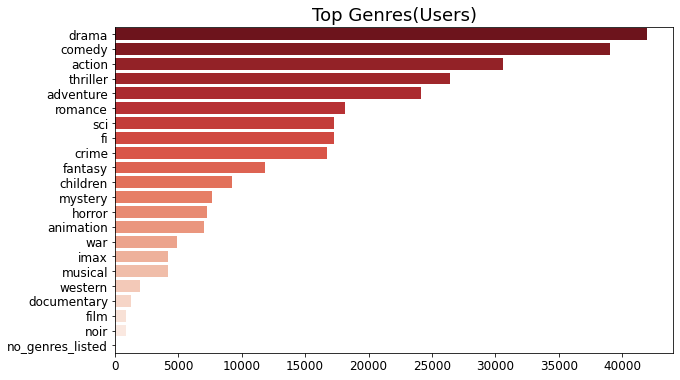

In [42]:
# plotting top unigrams across all users
plot_top_words(df, 'genres', 30, 1, 'Top Genres(Users)', 'Reds_r')

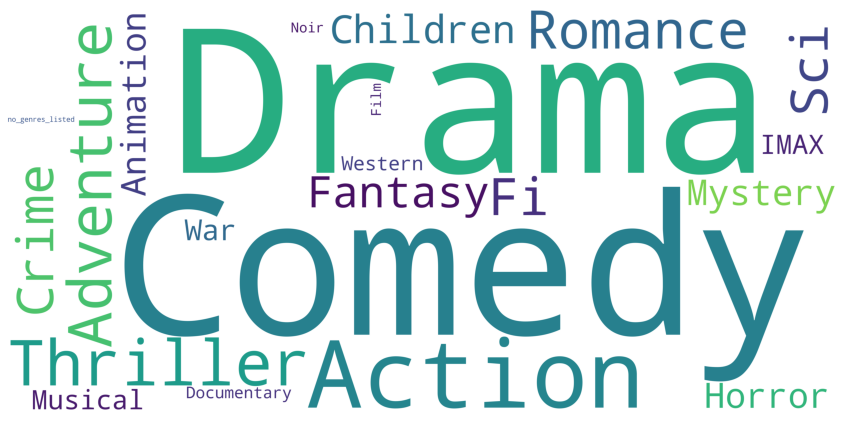

In [43]:
# plotting top unigrams across all users in a wordcloud
plot_wordcloud(df, 'genres', 'White')

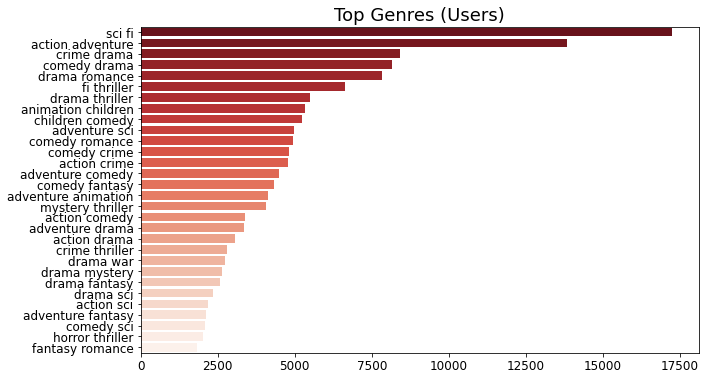

In [44]:
# plotting top bigrams across all users
plot_top_words(df, 'genres', 30, 2, 'Top Genres (Users)', 'Reds_r')

From the above chart, it seems that users have the highest preference for movies that are first, sci-fi, and second, action and adventure, where as the most popular movie genres produced were of sci-fi and then comedy and drama, although that is not too far behind on the above chart.

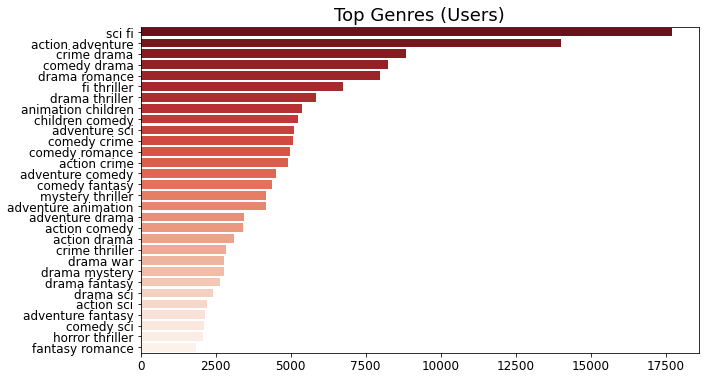

In [45]:
# plotting genres+tag from the merged dataframe across all users
plot_top_words(df_merged_tags, 'genres+tag', 30, 2, 'Top Genres (Users)', 'Reds_r')

Since there is no difference after adding the user generated tags into our merged dataframe, we will leave this feature out of our recommender system building efforts.

---

### Movie Tags across all users

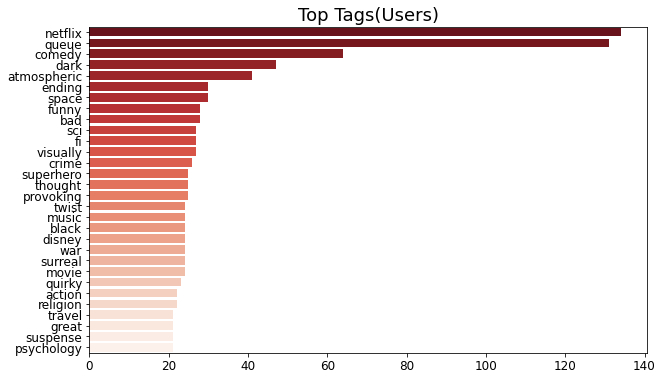

In [46]:
# plotting tags across all users
plot_top_words(tags, 'tag', 30, 1, 'Top Tags(Users)', 'Reds_r')

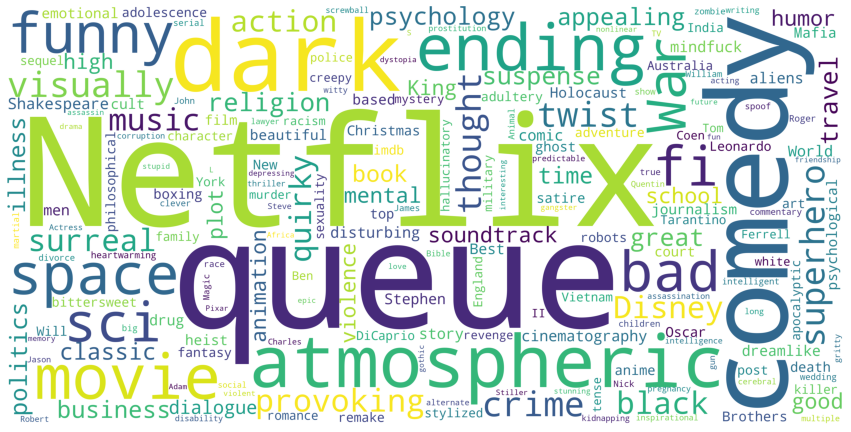

In [47]:
# plotting top tags across all users in a wordcloud
plot_wordcloud(tags, 'tag', 'White')

---

### Movie Title Years

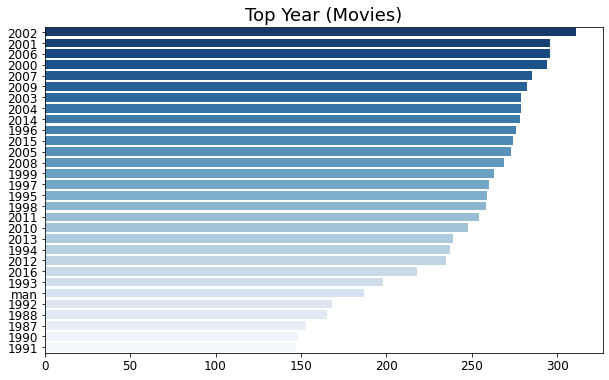

In [121]:
# plotting top words across all movies
plot_top_words(movies, 'title', 30, 1, 'Top Year (Movies)', 'Blues_r')

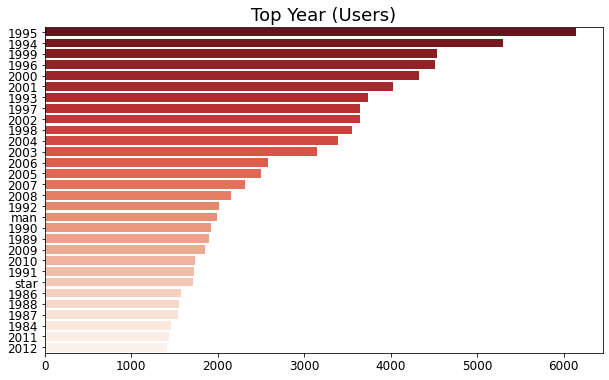

In [122]:
# plotting top words across all users
plot_top_words(df, 'title', 30, 1, 'Top Year (Users)', 'Reds_r')

Interestingly, it seems that movies there were most movies produced in 2002, followed by a few more years in the 2000s. However when compared to what users are watching, they seem to be watching movies from 1995 and 1994 the most. I think that the movie year could hold some merit as a feature to help get better recommendations.

Let's create a column that removes the year from our movie title. But before that, we will save our current `merged_df` file, and create a new instance of this as `temp_df`.

In [144]:
df.to_csv('./datasets/merged_users+movies.csv', index=False)

In [145]:
# creating temp df that extracts only the letters from our titles, and 
# dropping any nulls created as a result of this
temp_df = pd.read_csv('./datasets/merged_users+movies.csv')
temp_df['title_words'] = temp_df['title'].str.extract('(.+) \(')
temp_df.dropna(inplace=True)

temp_movies['title_words'] = temp_movies['title'].str.extract('(.+) \(')
temp_movies.dropna(inplace=True)

---

### Unique Movie Titles

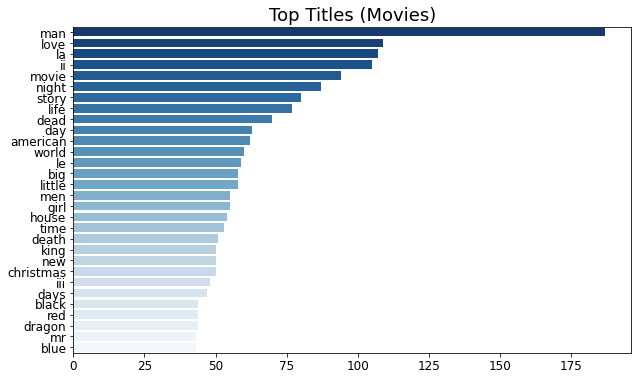

In [51]:
plot_top_words(temp_movies, 'title_words', 30, 1, 'Top Titles (Movies)', 'Blues_r')

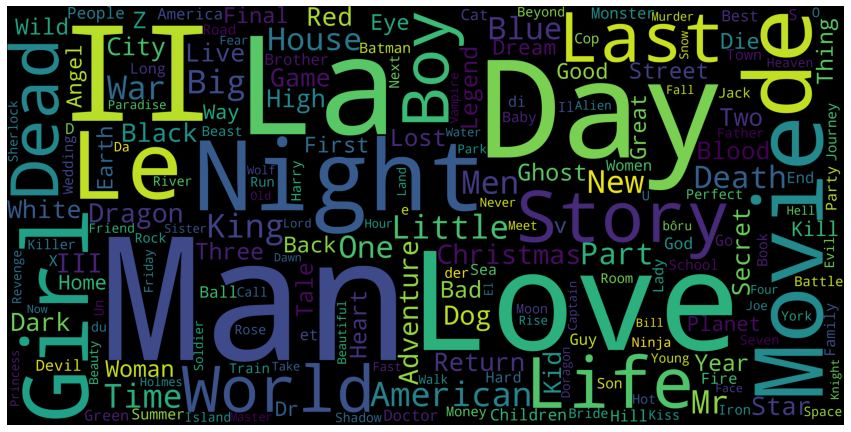

In [52]:
plot_wordcloud(movies, 'title', 'Black')

---

### Movie Titles across all users

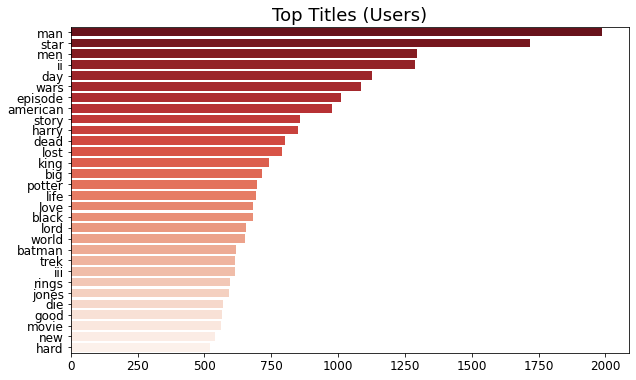

In [53]:
plot_top_words(temp_df, 'title_words', 30, 1, 'Top Titles (Users)', 'Reds_r')

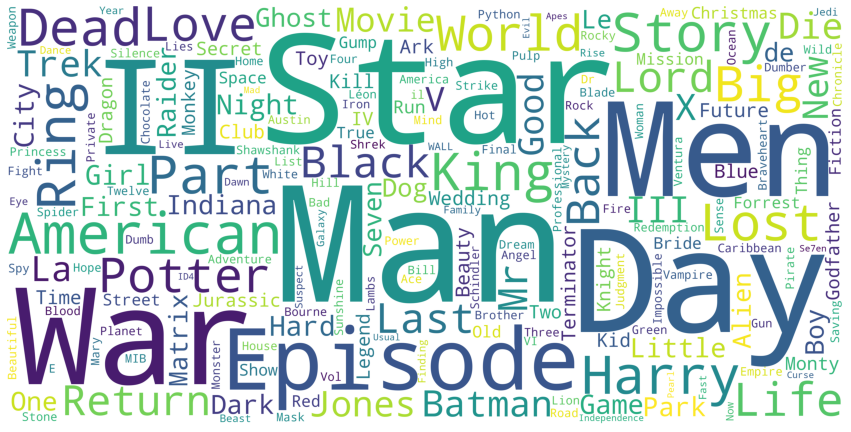

In [54]:
plot_wordcloud(df, 'title', 'White')

Now lets drop any additional columns created from our datasets, and save them. We will save the `temp_movies` df as well, the `mean_rating` and the `times_rated` columns may prove useful.

In [150]:
temp_movies.to_csv('./datasets/movies+avg_rating.csv', index=False)

In [151]:
df_merged_tags.to_csv('./datasets/merged_users+movies+tags.csv', index=False)

In [152]:
movies.to_csv('./datasets/movies.csv', index=False)

## External Research

Based on external research, I have found out that other than the `rmse` score, we also should consider another metric.

In a [Marketing Dive article](https://www.marketingdive.com/news/google-53-of-mobile-users-abandon-sites-that-take-over-3-seconds-to-load/426070/) published in 2016, it mentions that 53% of users abandon sites that don't load in **3 seconds**.

In a [A hubspot article](https://blog.hubspot.com/marketing/page-load-time-conversion-rates#:~:text=In%20fact%2C%20the%20highest%20ecommerce%20conversion%20rates%20occur%20on%20pages%20with%20load%20times%20between%200%2D2%20seconds.) it mentions that especially for ecommerce, the highest conversion rate occurred when pages loaded within **2 seconds**.

In a [A Forbes article](https://www.forbes.com/sites/peggyannesalz/2019/08/22/how-fast-is-fast-enough-mobile-load-times-drive-customer-experience-and-impact-sales/?sh=16973cb1ef31) it mentions that **1 second** is the magic number. 

Across advertising, it is the industry standard to attempt to show the user a personalized ad, regardless of ad format, within 1 second (1000ms). 

What does this mean for this project? This means that the time taken by the system to generate predictions has to be taken into consideration as a factor of the system's success. For this project, we will take **3 seconds** as the benchmark to hit, as most streaming services are paid, and as [this article on smartbear](https://smartbear.com/blog/5-10-15-seconds-how-long-will-you-wait-for-a-web-p/) mentions, the load times can differ depending on which part of the customer journey the customer is at. Since the user has already paid for the video streaming app, we shall assume that they will be willing to wait for **3 seconds** at most. 

If the use case is for YouTube, where they have a "free with ads" model, then load times would most likely have to hit the **1 second** benchmark.

---

In the next notebooks, we will start building some models to get recommendations of movies for users.